# 02806 - Social Data Analysis and Viszalization -  Project Assignment B

# 0. Package and data import

## 0.1 Package import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
import json
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import folium
from folium import plugins

## 0.2 Data import

### Trip Data

In [2]:
def getDataByYear(year):
    '''
    A function to combine the data records of a year to a dataframe.
    Due to different headers in the individual files (spaces, upper and
    lower case letters, etc.), these are normalized.
    Output is a Pandas Dataframe for the requested year.
    '''
    name=""
    df=[]
    
    for k in range(1,13):
        if k<10:
            name = str(year)+"0"+str(k)
        else:
            name = str(year)+""+str(k)
        name +="-citibike-tripdata.csv"
        
        df.append(pd.read_csv('data/'+name))
        #set columns to lower case
        df[k-1].columns = map(str.lower, df[k-1].columns)
        #Filter data 
        df[k-1].columns = [x.replace(" ","") for x in list(df[k-1].columns)]
        df[k-1]["starttime"] = pd.to_datetime(df[k-1]["starttime"], infer_datetime_format=True)
        df[k-1]["stoptime"] = pd.to_datetime(df[k-1]["stoptime"], infer_datetime_format=True)
        
    return pd.concat(df,ignore_index=True)

In [3]:
#Dataset of years 2016-2018
df16=getDataByYear(2016)
df17=getDataByYear(2017)
df18=getDataByYear(2018)

In [4]:
#Merge all trip data
frames = [df16,df17,df18]
df_trips=pd.concat(frames)

In [5]:
df_trips.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender
0,923,2016-01-01 00:00:41,2016-01-01 00:16:04,268.0,Howard St & Centre St,40.719105,-73.999733,3002.0,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,2016-01-01 00:00:45,2016-01-01 00:07:04,476.0,E 31 St & 3 Ave,40.743943,-73.979661,498.0,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,2016-01-01 00:00:48,2016-01-01 00:10:37,489.0,10 Ave & W 28 St,40.750664,-74.001768,284.0,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,2016-01-01 00:01:06,2016-01-01 00:15:56,268.0,Howard St & Centre St,40.719105,-73.999733,3002.0,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,2016-01-01 00:01:12,2016-01-01 00:25:52,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


### Station data

In [6]:
#Import data from json url. Delete unnecessary columns
with urllib.request.urlopen("https://feeds.citibikenyc.com/stations/stations.json") as url:
    data = json.loads(url.read().decode())
    del data['executionTime']
    data = data['stationBeanList']

#Add data from json objects to list. Only include necessary fields
stations = []
for station in data:
    stations.append([station['id'], station['stationName'], station['latitude'], station['longitude'], station['totalDocks']])

#make dataframe of station info from list derived from json object
df_stations = pd.DataFrame(stations, columns=["id", "stationname", "lat", "long", "capacity"])

In [7]:
df_stations.head()

,id,stationname,lat,long,capacity
0,72,W 52 St & 11 Ave,40.767272,-73.993929,55
1,79,Franklin St & W Broadway,40.719116,-74.006667,33
2,82,St James Pl & Pearl St,40.711174,-74.000165,27
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,62
4,119,Park Ave & St Edwards St,40.696089,-73.978034,19


# 1. Motivation.
What is your dataset?

Why did you choose this/these particular dataset(s)?

What was your goal for the end user's experience?


# 2. Basic stats. 

Let's understand the dataset better


Write about your choices in data cleaning and preprocessing


Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

#### Trip Data
While the trip dataset is a big one, with nearly 48M rows (!) and 15 columns, it can be reduced a great deal by removing unnecessary columns. For the analyses only the columns with time and ID will be of interest. Station names and coordinates can later be derived from the other data set, *Station Data*. <br>
For the exploratory analysis however, both station names and the coordinates are convenient to keep. 

In [8]:
df_trips.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender
0,923,2016-01-01 00:00:41,2016-01-01 00:16:04,268.0,Howard St & Centre St,40.719105,-73.999733,3002.0,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,2016-01-01 00:00:45,2016-01-01 00:07:04,476.0,E 31 St & 3 Ave,40.743943,-73.979661,498.0,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,2016-01-01 00:00:48,2016-01-01 00:10:37,489.0,10 Ave & W 28 St,40.750664,-74.001768,284.0,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,2016-01-01 00:01:06,2016-01-01 00:15:56,268.0,Howard St & Centre St,40.719105,-73.999733,3002.0,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,2016-01-01 00:01:12,2016-01-01 00:25:52,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


**Figure 2.1** Trip Data

In [9]:
df_trips.shape

(47758651, 15)

#### Station Data
After removing unnecessary columns, the station data set consists of the station ID, the station name, the coordinates and the capacity of every station. The essential data of this dataset is the *capacity*. Keeping the station name and coordinates in this dataset, as opposed to in the trip dataset, is good for avoiding redundancy of data. When those columns are needed, they can easily be mapped to the trip data by the IDs.

In [10]:
df_stations.head()

,id,stationname,lat,long,capacity
0,72,W 52 St & 11 Ave,40.767272,-73.993929,55
1,79,Franklin St & W Broadway,40.719116,-74.006667,33
2,82,St James Pl & Pearl St,40.711174,-74.000165,27
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,62
4,119,Park Ave & St Edwards St,40.696089,-73.978034,19


**Figure 2.2** Station Data

#### Exploratory Analysis

First: Getting a look of which stations are the most popular, and how many trips each station have. As this is only to get an estimate, only the from-trips are included. 

In [33]:
startStations=pd.DataFrame({'count' : df_trips.groupby('startstationname').startstationid.count()}).reset_index()
startStations=startStations.sort_values(by=['count'],ascending=False)
startStaTop=startStations[0:50]
startStaBottom=startStations[-50:]
#endStations=pd.DataFrame({'count' : df_trips.groupby('endstationname').endstationid.count()}).reset_index()
#endStations=endStations.sort_values(by=['count'],ascending=False)
#endSta=endStations[0:50]

Plotting the top and bottom 50 stations provides for an overview of the difference in activity of the stations in the data. As one can see in **Figure 2.3** below, the activity difference is quite substantial.

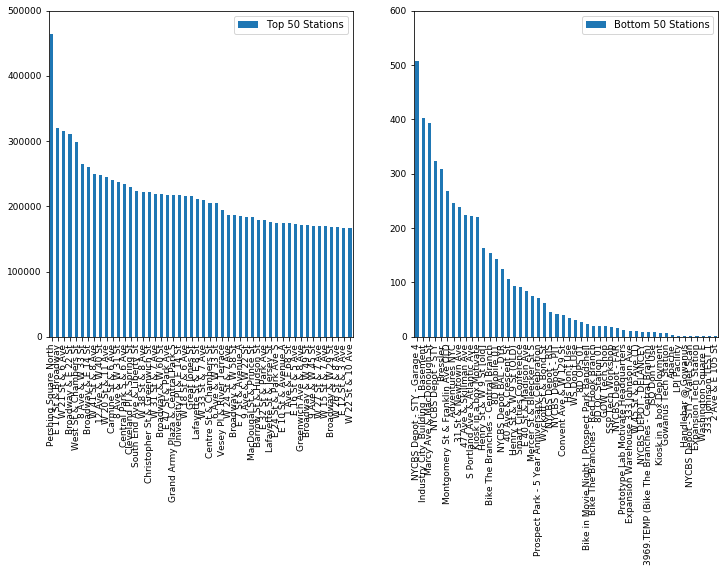

In [37]:
#Plot the histogram with 50 bins
f, ((ax1,ax2)) = plt.subplots(1,2,figsize=(30,15));
my_cmap = ListedColormap(sns.color_palette('husl').as_hex())
startStaTop.plot(kind='bar',xticks=startStaTop.index,rot=90,fontsize=9,figsize=(12,6),ax=ax1)
ax1.set_xticklabels(startStaTop.startstationname);
ax1.legend(['Top 50 Stations'])
ax1.set_ylim([0,500000])

startStaBottom.plot(kind='bar',xticks=startStaBottom.index,rot=90,fontsize=9,figsize=(12,6),ax=ax2)
ax2.set_xticklabels(startStaBottom.startstationname);
ax2.legend(['Bottom 50 Stations'])
ax2.set_ylim([0,600])
plt.savefig('demo.png', transparent=True)

**Figure 2.3** Barchart of top and ottom 50 stations

As a big part of the analysis is going to deal with maps, a scatter plot of the stations is good to have. Already from the scatter plot in **Figure 2.4**, one can see where there are more stations. 

In [17]:
#Stations in trip dataset
m1 = folium.Map([40.730610, -73.935242], zoom_start=11)
# mark each station as a point
scatter_data = df_stations.drop_duplicates()
for index, row in scatter_data.iterrows():
    folium.CircleMarker([row['lat'], row['long']],
                        radius=3,
                        popup=str(row),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m1)
m1

**Figure 2.4** Scatterplot of stations

Later on, the demand of stations will be analysed and predicted. In order to understand the data better for this analysis, the heatmap in **Figure 2.5** has been created. The heatmap, that plots the trips of every station, gives a good overview of the station activity - and hence an idea of the demand.

In [ ]:
start_stat=pd.DataFrame({'count' : df_trips.groupby(['startstationid','startstationlatitude','startstationlongitude']).startstationid.count()}).reset_index()
start_stat = start_stat.rename(columns={'startstationid': 'id', 'startstationlatitude': 'lat','startstationlongitude': 'long'})

end_stat=pd.DataFrame({'count' : df_trips.groupby(['endstationid','endstationlatitude','endstationlongitude']).startstationid.count()}).reset_index()
end_stat = end_stat.rename(columns={'endstationid': 'id', 'endstationlatitude': 'lat','endstationlongitude': 'long'})

start_end = pd.merge(start_stat, end_stat, left_on=['id','lat', 'long'], 
                     right_on=['id','lat', 'long'])
start_end['count'] = start_end['count_x'] + start_end['count_y']
start_end = start_end.drop(['count_x', 'count_y'], axis=1)
start_end.head()

In [38]:
k = folium.Map([40.730610, -73.935242], zoom_start=12)

# convert to (n, 2) nd-array format for heatmap
stationArr = start_end[['lat', 'long', 'count']].as_matrix()
max_amount = float(start_end['count'].max())

hm_wide = plugins.HeatMap(stationArr,
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=15, blur=10, 
                   max_zoom=1)

k.add_child(hm_wide)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


**Figure 2.5** Heatmap of station activity

# 3. Data Analysis

Describe your data analysis and explain what you've learned about the dataset.

If relevant, talk about your machine-learning.

## 3.1. Hotspots

## 3.2. Demand Analysis and Prediction

#### Delete unnecessary columns and change to datetime objects

In [39]:
df_demand = df_trips.copy()
del_cols = ['tripduration', 'startstationname', 'startstationlatitude', 'startstationlongitude', 'endstationname',
       'endstationlatitude', 'endstationlongitude', 'usertype', 'birthyear', 'gender', 'bikeid']
df_demand = df_demand.drop(del_cols, axis=1)
df_demand['startday'] = df_demand['starttime'].dt.dayofweek
df_demand['stopday'] = df_demand['stoptime'].dt.dayofweek
df_demand['starttime'] = df_demand['starttime'].dt.hour
df_demand['stoptime'] = df_demand['stoptime'].dt.hour

KeyboardInterrupt: 

#### Count bikes in and out for weekdays and hours.

In [ ]:
df_demand_start = df_demand[['startstationid', 'startday','starttime']]
df_demand_stop = df_demand[['endstationid', 'stopday', 'stoptime']]
df_demand_start= pd.DataFrame({'startcount' : df_demand_start.groupby(['startstationid', 'startday', 'starttime']).size()}).reset_index()
df_demand_stop = pd.DataFrame({'stopcount' : df_demand_stop.groupby(['endstationid', 'stopday', 'stoptime']).size()}).reset_index()

#### Merge in and out data. Add netcount of bikes in each station for every hour and weekday

In [ ]:
df_demand_count = pd.merge(df_demand_start, df_demand_stop, left_on=['startstationid', 'startday', 'starttime'], 
                    right_on=['endstationid', 'stopday', 'stoptime'])
df_demand_count = df_demand_count.drop(['endstationid', 'stopday', 'stoptime'], axis=1)
df_demand_count = df_demand_count.rename(columns={'startstationid': 'id', 'startday': 'weekday','starttime': 'hour'})
df_demand_count['id'] = df_demand_count['id'].apply(lambda x : int(x))

#Calculate netcount
df_demand_count['netcount'] = df_demand_count['stopcount'] - df_demand_count['startcount']

In [ ]:
df_demand_count.head()

### 3.2.1 Demand Analysis

#### Find stations that have both incoming and outgoing bikes

In [ ]:
df2_demand = df_demand[['startstationid']].drop_duplicates()
df3_demand = df_demand[['endstationid']].drop_duplicates()
df4_demand = pd.merge(df2_demand,df3_demand, how='inner', left_on='startstationid', right_on='endstationid')
df4_demand = df4_demand[['startstationid']].drop_duplicates().dropna()
df4_demand['startstationid'] = df4_demand['startstationid'].apply(lambda x : int(x))
df4_demand.columns = ['id']

#### Find stations that are in both dataset, and merge these. Save data to .csv file.

In [ ]:
df_demand_common_stations = pd.merge(df_stations, df4_demand, how='inner', on=['id'])
df_demand_common_stations.to_csv('common_stations.csv', index=False)

#### Calculate demand

In [ ]:
df_demand_analysis = pd.merge(df_demand_count,df_demand_common_stations[['id','capacity']],on='id', how='left')

#drop rows with stations that are not in capacity dataset
df_demand_analysis = df_demand_analysis[np.isfinite(df_demand_analysis['capacity'])]

#Demand function. Function is negated to give stations in higher demand a higher value
df_demand_analysis['demand'] = -(df_demand_analysis['netcount'])/df_demand_analysis['capacity']

#Convert id to int
#df_demand_analysis['id'] = df_demand_analysis['id'].apply(lambda x : int(x))

#drop rows with stations that have 0 in capacity
df_demand_analysis = df_demand_analysis[df_demand_analysis.capacity != 0]

#drop duplicates
df_demand_analysis = df_demand_analysis.drop_duplicates() 

In [ ]:
df_demand_analysis.head()

#### Save filtered data to .csv file

In [ ]:
df_demand_analysis.to_csv('capacity2.csv', index=False)

### 3.2.2. Demand Prediction

#### Define input features and target values. Shuffle the data.

In [ ]:
# Defines input features and target values
X = df_demand_count[['id','weekday','hour']].values
y1 = df_demand_count[['netcount']].values

# Data Prep
y = np.array(["high demand" if n<0 else "low demand" for n in y1])
class_idx = {'high demand':1, 'low demand':0}

y = np.array([class_idx[v] for v in y])
y = np.eye(2)[y]


# Shuffles the data
random_idx = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(random_idx)

X = X[random_idx]
y = y[random_idx]

#### Split the data into training and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train data

*For Jupyter Notebook*

In [ ]:
DT = DecisionTreeClassifier(min_samples_split=13, criterion = "entropy")
DT.fit(X_train, y_train)
predictions = DT.predict(X_test)

*For Observable Notebook* <br>
max_depth = 5 for the desicion tree to fit into the observable notebook

In [ ]:
DT_obs = DecisionTreeClassifier(min_samples_split=13, max_depth = 5, criterion = "entropy")
DT_obs.fit(X_train, y_train)
predictions_obs = DTobs.predict(X_test)

#### Accuracy 

*For Jypyter Notebook*

In [ ]:
true = y_test.argmax(axis=1)
correct_preds = np.equal(true, predictions.argmax(axis=1))
sum(correct_preds) / len(true)

*For Observable Notebook*

In [ ]:
true = y_test.argmax(axis=1)
correct_preds = np.equal(true, predictions_obs.argmax(axis=1))
sum(correct_preds) / len(true)

#### Calculate the Mean Squared Error (MSE)

In [ ]:
def MSE(X, y, DT):
        
        # Predict
        yhat = DT.predict(X)
    
        # Calculate MSE
        return np.mean((y-yhat)**2)

*For Jupyter Notebook*

In [ ]:
MSE(X_test, y_test, DT)

*For Observable Notebook*

In [ ]:
MSE(X_test, y_test, DT_obs)

#### Create desicion tree

In [ ]:
def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier

    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.

    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        count_labels = zip(clf.tree_.value[node_index, 0], labels)
        node['name'] = ', '.join(('{} of {}'.format(int(count), label)
                                  for count, label in count_labels))
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['name'] = '{} > {}'.format(feature, threshold)
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
    return node

#### Create JSON file with decision tree

In [ ]:
feature_names = ['StationID', 'Weekday', 'Hour']
target_names = ["LD", "HD"]

r = rules(DT_obs, feature_names, target_names)

with open('desicion_tree.json', 'w') as f:
    f.write(json.dumps(r))

# 4. Genre. Which genre of data story did you use?

Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

# 5. Visualizations.

Explain the visualizations you've chosen.

Why are they right for the story you want to tell?

# 6. Discussion. Think critically about your creation
What went well?,
What is still missing? What could be improved?, Why?